# this notebook performs the subsampling of learned sequences so that the number of sequences of learning and learned be equeal. for each subsampling we perform the clustering.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import seaborn as sns
import pandas as pd
import mtools as mot
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:
fs = 20# sampling freq
dt = 1/fs  # bin size of each time index
dy = 0.001 # bin size for position histogram. Since we will smooth the histogram anyways, the smaller the better (approaching Kernel Density Estimation).
sigma_y = 0.05 # I do not know the size of the animal. So, assume it to be 1% of the track.
sigma_yidx = sigma_y/dy  # Convert the position unit to unit of array index.
yedges = np.arange(0-dy/2, 1+dy, dy)  # edges for histogram
y_ax = pf.MidAx(yedges)  # position axis, mainly for plotting. Since edges are just for histogram.
allfolders2=['478','481','483','485']

In [3]:
import configparser
import os

# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']


In [4]:
nrm = np.load('nrm.npy',allow_pickle=True)
min_ratio = 1 # threshold to exclude bad templates
import copy

# Initialization for running subsampling for entropy
clusteringmethod = 'AHC'
SpeedLimint=0# is not applied anymore

if clusteringmethod =='DB':# clustering algorithgm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)

In [5]:
speed_thr=0
n_subsampling_netropy = 50

In [8]:
import pickle
fol1='485'
#sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients'+'Randomized_seqs',allow_pickle=True)
sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)
#temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
#temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
#temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_modified_test2'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)

import random

Masks = sessinfo_and_mask['Masks']

sess_info = sessinfo_and_mask['sess_info']

smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr

temp_info_subsampling={}
seq_msk_ing=(np.asanyarray(Masks['bursts_phase'])==0)
seq_msk_ed=(np.asanyarray(Masks['bursts_phase'])==1)
seq_len_ing=np.sum((np.asanyarray(Masks['bursts_phase'])==0))# subsampling number
plot_figure=False# do not show the similarity matrix

subsampling_restults={'cluster_dist':{}}


for ss in range(n_subsampling_netropy):# subsampling
    print(ss)
    seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
    bursts=sess_info['bursts']
    learned_new_phase_mask=np.zeros(np.sum(seq_msk_ed)).astype(bool)

    seq_learnedg=list(np.asarray(seqs)[seq_msk_ed])# all learned sequences
    burst_learned=list(np.asarray(bursts)[seq_msk_ed])# all learned bursts
    # Draw n random indices
    rnd_indices = random.sample(range(len(seq_learnedg)), seq_len_ing)# random saples withe length of learning data(shorter)
    learned_new_phase_mask[rnd_indices]=True
    new_mask=np.hstack((np.ones(np.sum(seq_msk_ing)).astype(bool),learned_new_phase_mask ))# Learnings set to 1, samples learned set to 1

    #correct_mask_subsampled=seq_msk_ed[rnd_indices]

    new_cond_mask=np.asarray(Masks['bursts_cond'])[new_mask]
    new_phase_mask=np.asarray(Masks['bursts_phase'])[new_mask]
    new_bursts_sess=np.asarray(Masks['bursts_sess'])[new_mask]


    new_correct_failed_mask=np.asarray(Masks['correct_failed_seqs'])[new_mask]

    seq_new=np.asarray(seqs)[new_mask]
    burst_new=np.asarray(bursts)[new_mask]
    id_peaks_new=np.asarray(sess_info['id_peaks'])[new_mask]
    #speed_seq_new= np.asarray(sess_info['speed_seq'])[new_mask]
    speed_seq_new= np.asarray(Masks['speed_seq'])[new_mask]

    # Use indices to get data from both lists
    random_seq_ed = [seq_learnedg[i] for i in rnd_indices]# get random subsampling bursts of learned data(longer) with the length of the learning bursts
    random_burst_ed = [burst_learned[i] for i in rnd_indices]
    
    # seq_new=list(np.asarray(seqs)[seq_msk_ing])+random_seq_ed# merging learnind and subsampled learned sequences
    # burst_new=list(np.asarray(bursts)[seq_msk_ing])+random_burst_ed


# seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# bursts=sess_info['bursts']

    #id_peaks=sess_info['id_peaks']
    #*************** compute clusters from sequences
    repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seq_new,nrm);
    ids_clust = mot.cluster(bmat,zmat,clstr_param)
    temp_info = mot.templates(burst_new,seq_new,nrm,ids_clust,min_ratio = min_ratio)
    print('cluster', temp_info['exclude'] ,'is removed')
    #temp_info_org=np.copy(temp_info['template'])
    temp_info_test = copy.deepcopy(temp_info)
    temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seq_new,burst_new,plot_figure,min_ratio=.1,z_thr=2.5)
    #id_peaks=dats['sp_idpeak']
    #sess_info['ids_clust'] = temp_info_new['ids_clust'][0]



    temp_info_subsampling[ss]=temp_info_new

    temp_info_subsampling[ss]['new_cond_mask']=new_cond_mask
    temp_info_subsampling[ss]['new_phase_mask']=new_phase_mask
    temp_info_subsampling[ss]['new_correct_failed_mask']=new_correct_failed_mask
    temp_info_subsampling[ss]['new_id_peaks']=id_peaks_new
    temp_info_subsampling[ss]['speed_seq_new']=speed_seq_new
    temp_info_subsampling[ss]['new_bursts_sess']=new_bursts_sess

#with open(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
    #pickle.dump(temp_info_subsampling, f) 

0


C:\Users\hamed\AppData\Local\Temp\ipykernel_13904\1728983188.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_learnedg=list(np.asarray(seqs)[seq_msk_ed])# all learned sequences
C:\Users\hamed\AppData\Local\Temp\ipykernel_13904\1728983188.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_new=np.asarray(seqs)[new_mask]
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:653: RuntimeWarning: invalid value encountered in true_divide
  cofseq=(itax@vec.transpose())/nvec


cluster [] is removed
(33, 33)
exclude cluster is  [] mixed clusters are  [5.70172679 4.         5.        ]
(32, 32)
exclude cluster is  [] mixed clusters are  [ 5.47831241 10.         18.        ]
(31, 31)
exclude cluster is  [] mixed clusters are  [4.7939967 0.        4.       ]
(30, 30)
exclude cluster is  [] mixed clusters are  [ 4.5076113  9.        15.       ]
(29, 29)
exclude cluster is  [] mixed clusters are  [4.41674173 3.         4.        ]
(28, 28)
exclude cluster is  [] mixed clusters are  [ 3.9039698 13.        14.       ]
(27, 27)
exclude cluster is  [] mixed clusters are  [3.71462074 2.         3.        ]
(26, 26)
exclude cluster is  [] mixed clusters are  [ 3.54089362 11.         12.        ]
(25, 25)
exclude cluster is  [] mixed clusters are  [ 3.34200406  7.         12.        ]
(24, 24)
exclude cluster is  [] mixed clusters are  [ 3.47022177 10.         11.        ]
(23, 23)
exclude cluster is  [] mixed clusters are  [3.15864875 2.         5.        ]
(22, 22)
exc

In [11]:
cell_types='All'
place_cell_name='All'
animallist=['478','481','483','485']
burst_len='0.5s'
descriotor='No_chunk_'+burst_len+'_transients'#+'Randomized_seqs'

for fol1 in animallist:
        
    #ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
    temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)



In [ ]:
filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

In [ ]:
filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

In [8]:
sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)

import random
n_subsampling_netropy = 1
Masks = sessinfo_and_mask['Masks']

sess_info = sessinfo_and_mask['sess_info']

In [ ]:
Get_clustered_seq.ipynb

In [28]:
    filename = fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients'

    #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info= data_all_tasks['sess_info']

In [35]:
data_all_tasks['Masks']

{'conditions': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [30]:
sess_info.keys()

dict_keys(['trial_data', 'pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'id_peaks', 'bursts', 'speed', 'passid', 'lin_pos', 'loc', 'corr', 'Spike_times_cells', 't', 'extract', 'seqs', 'trial_idx_mask', 'Spike_binary_cells', 'Spike_binary', 'ids_clust', 'template'])

In [26]:
Masks['cell_correct']

KeyError: 'cell_correct'

In [13]:
sess_info2=copy.deepcopy(sess_info)
Masks2=copy.deepcopy(Masks)
ss=0
sess_info2['seqs']=temp_info_subsampling[ss]['seqs'][0]
sess_info2['ids_clust']=temp_info_subsampling[ss]['ids_clust'][0]
sess_info2['id_peaks']=temp_info_subsampling[ss]['new_id_peaks']
sess_info2['bursts']=temp_info_subsampling[ss]['bursts'][0]

Masks2['bursts_cond']=temp_info_subsampling[ss]['new_cond_mask']
Masks2['bursts_phase']=temp_info_subsampling[ss]['new_phase_mask']
Masks2['correct_failed_seqs']=temp_info_subsampling[ss]['new_correct_failed_mask']

Masks2['speed_seq']=temp_info_subsampling[ss]['speed_seq_new']
Masks2['phase_mask']=temp_info_subsampling[ss]['new_phase_mask']
Masks2['cond_mask']=temp_info_subsampling[ss]['new_cond_mask']
Masks2['correct_failed_mask']=temp_info_subsampling[ss]['new_correct_failed_mask']


Masks2['bursts_sess']=temp_info_subsampling[ss]['new_bursts_sess']

In [14]:
cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

In [15]:
type_name='Correct'
phname='learned'

In [16]:
trial_type=1
conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']

session_mask={'20220215_gcamp6f485_task_learning.mat': 0,
 '20220217_gcamp6f485_task_learning.mat': 1,
 '20220218_gcamp6f485_task_learning.mat': 2,
 '20220307_gcamp6f485_task_learned.mat': 3,
 '20220308_gcamp6f485_task_learned.mat': 4,
 '20220309_gcamp6f485_task_learned.mat': 5,
 '20220310_gcamp6f485_task_learned.mat': 6,
 '20220316_gcamp6f485_task_learned.mat': 7}

cond_names = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
sessin_numbers=np.arange(len(session_mask))

odd_even=None# all trials

phase='Learned'

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def get_distinguishable_colors(n):
    base_colors = [
        "#FF5733", # Red
        "#33FF57", # Green
        "#3357FF", # Blue
        "#FFD700", # Yellow
        "#FF33FF", # Magenta
        "#33FFFF", # Cyan
        "#800080", # Purple
        "#00FF00", # Lime
        "#FFA500", # Orange
        "#0000FF", # Navy
    ]

    if n <= len(base_colors):
        return base_colors[:n]
    else:
        # Interpolate between the base colors if more colors are needed
        colors = base_colors[:]
        additional_colors_needed = n - len(base_colors)
        for i in range(additional_colors_needed):
            color1 = base_colors[i % len(base_colors)]
            color2 = base_colors[(i + 1) % len(base_colors)]
            new_color = interpolate_colors(color1, color2, 0.5)
            colors.append(new_color)
        return colors

def interpolate_colors(color1, color2, factor):
    c1 = np.array([int(color1[i:i+2], 16) for i in (1, 3, 5)])
    c2 = np.array([int(color2[i:i+2], 16) for i in (1, 3, 5)])
    c_new = (c1 * (1 - factor) + c2 * factor).astype(int)
    return '#' + ''.join(f'{i:02X}' for i in c_new)

# Example usage
n = 15
colors = get_distinguishable_colors(n)
print(colors)
colorlist = get_distinguishable_colors(np.max(sess_info['ids_clust'])+2)

['#FF5733', '#33FF57', '#3357FF', '#FFD700', '#FF33FF', '#33FFFF', '#800080', '#00FF00', '#FFA500', '#0000FF', '#99AB45', '#33ABAB', '#99977F', '#FF857F', '#9999FF']


In [18]:
if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'


In [19]:
def generate_hex_colors(n):
    
    color_list = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        if color in color_list:
            continue
        color_list.append(color)

    return color_list



colorlist = generate_hex_colors(np.max(sess_info['ids_clust'])+2)

n_clusters=np.max(sess_info['ids_clust'])+1

In [22]:
phase_name='Learned'

In [24]:
Masks['cell_correct']

KeyError: 'cell_correct'

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3338: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_phase= np.asarray(Masks['phases'])==phase# learning or learned
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3339: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_phase_seqs= np.asarray(Masks['bursts_phase'])==phase
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3341: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_phase_cell= [ np.asarray(x) == phase for x in Masks['cell_phase'] ]
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3344: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_phase_fr= np.asarray(Masks['fr_phase'])=

KeyError: 'cell_correct'

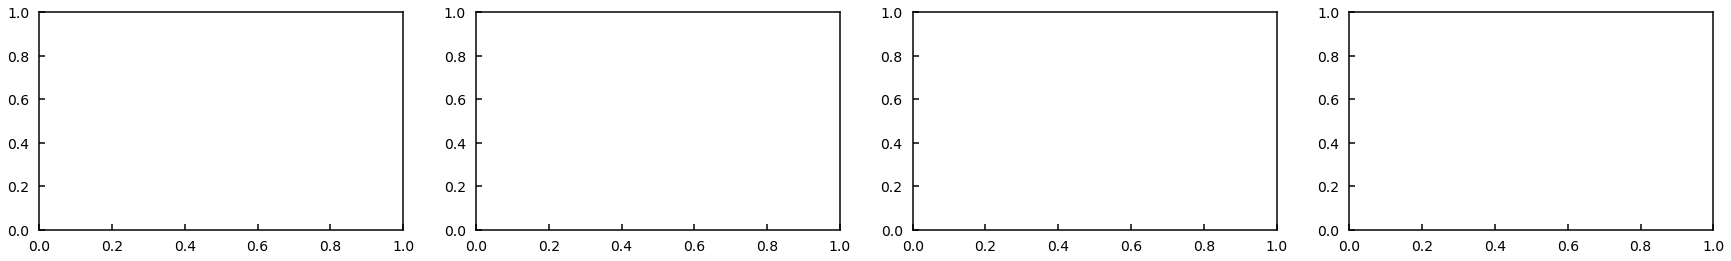

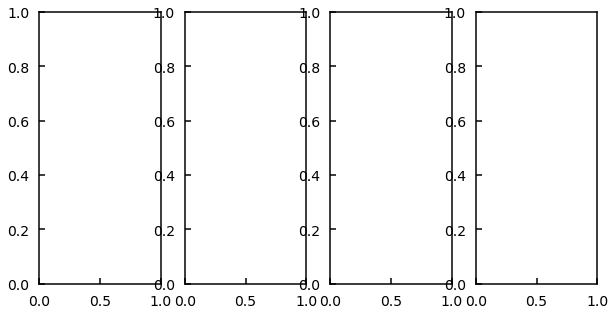

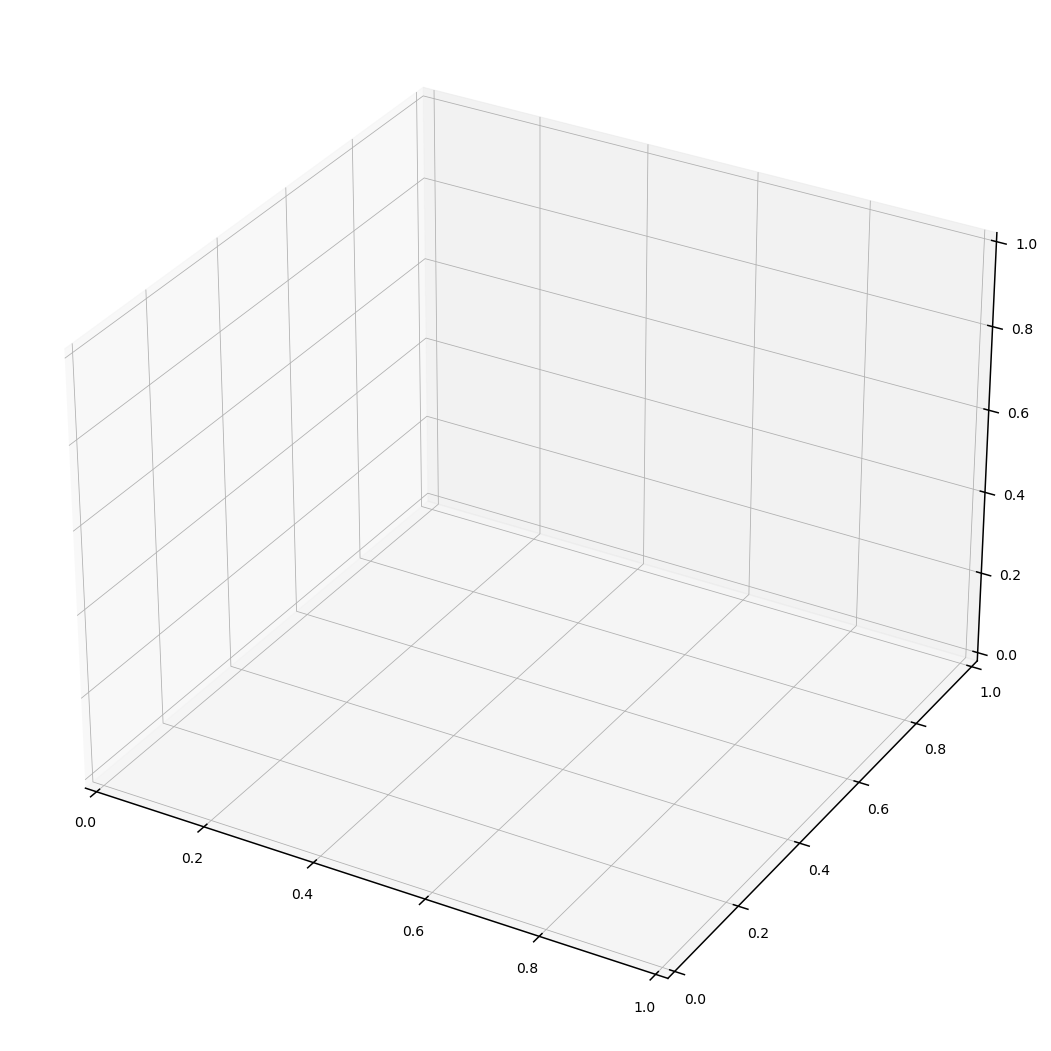

In [23]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)
tasks=['sampling','outward','reward','inward']

plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


fig2,ax2=plt.subplots(1,4,figsize=(30,4))

fig,ax=plt.subplots(1,4,figsize=(10,5))

figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
#figs.patch.set_facecolor('black')
cond_clst_idx={}
for icond,cond_number in enumerate(cond_numbers.keys()):

    name_cond=phase_name+' '+type_name

    if ('outward' in cond_number) | ('inward' in cond_number):
        speed_thr=0
        
    elif ('sampling' in cond_number) | ('reward' in cond_number):
        #continue
        speed_thr=0
    # add the mask for speed. speed threshold is set to 5.
    #speed_thr=0
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    run_data_all = mot.apply_masks_test(sess_info2,Masks2,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    trial_number=len(np.unique(run_data_all['trial_idx_mask']))



    ### plot 3d animal's position+speed
    ax5s.set_title(name_cond,fontsize=58,color='black')
    X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
    Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
    speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
    colrlst = np.asarray(colorlist)[run_data_all['ids_clust']]
    ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=100,c=colrlst,alpha=.51,edgecolor='black')
    ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='grey',alpha=.1)
    #ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='grey',alpha=.009)

    ax5s.set_facecolor('w') 
    ax5s.grid(False) 
    # ax5s.w_xaxis.pane.fill = False
    # ax5s.w_yaxis.pane.fill = False
    # ax5s.w_zaxis.pane.fill = False
    ax5s.xaxis.pane.fill = False
    ax5s.yaxis.pane.fill = False
    ax5s.zaxis.pane.fill = False

    ax5s.tick_params(axis='z', colors='gray',labelsize=22)
    ax5s.view_init(elev=-90, azim=90)
    #ax5s.view_init(elev=25, azim=-45)
    #ax5s.view_init(elev=0, azim=0)


    cond_clst_idx[cond_number] = run_data_all['ids_clust']

    #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
    #sns.set_palette(sns.color_palette(colorlist))
    sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
    for ic in range(len(ax[icond].patches)):
        ax[icond].patches[ic].set_facecolor(colorlist[ic])





    ax[icond].text(2,-1,'trial # = ' +str(trial_number))
    #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
    ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
    #ax[icond].set_xlim(0, 80)
    ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
    ax[icond].set_ylabel('Cluster #',fontsize=14)
    ax[icond].set_xlabel('Sequence counts',fontsize=14)

    #plt.ylim([-1,np.max(sess_info['ids_clust'])])



    ispk=0
    for sspk in run_data_all['spike_idx_cells']:
        ax2[icond].eventplot(sspk,lineoffsets=ispk)
        ispk+=1
#     ax2[icond].set_title(cond_number+'  '+fol1+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
#     ax2[icond].set_ylabel('cell#')


# #plt.suptitle(fol1+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
# plt.tight_layout()